Logs
- [2025/03/06]   
  First version of the application of genetic algorithm to two-dimensional 
  optimization problem with Ackley's function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as plt_cm

import plotly.graph_objects as go   # pip install plotly nbformat (and restart kernel)

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

### Problem statement

$$
  \argmin_{(x_1, x_2) \in [-5, 5]^2} 
    f(x_1) = -20 \exp \left( -0.2 \sqrt{\frac{x_1^2 + x_2^2}{2}}\right)
      -\exp\left( \frac{\cos(2\pi x_1) + \cos(2\pi x_2)}{2}\right) 
      + 20 + \exp(1)
$$

In [3]:
def obj_func(x1, x2, a=20, b=0.2, c=2.*np.pi):
  term1 = -a*np.exp(-b*np.sqrt((x1**2 + x2**2)/2.))
  term2 = -np.exp((np.cos(c*x1) + np.cos(c*x2))/2.)
  return term1 + term2 + a + np.exp(1) 

The plot of function $f(x_1)`$

In [4]:
%matplotlib inline
N_x1 = 100
N_x2 = 100
x1_range = [-5., 5.]
x2_range = [-5., 5.]
x1_space = np.linspace(x1_range[0], x1_range[1], N_x1)
x2_space = np.linspace(x2_range[0], x2_range[1], N_x2)
x1_mesh, x2_mesh = np.meshgrid(x1_space, x2_space)

f_vals = obj_func(x1_mesh, x2_mesh)

fig = go.Figure(data=[go.Surface(z=f_vals, x=x1_space, y=x2_space, 
                                  colorscale="Inferno", opacity=1)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

r = 1.5
camera = {"eye": {"x": r, "y": r, "z": r}}
fig.update_layout(autosize=False, width=500, height=400, 
                  scene={"xaxis_title": "<i>x</i>",
                         "yaxis_title": "<i>y</i>",
                         "zaxis_title": "<i>f(x, y)</i>",
                         "aspectratio": {"x": 1, "y": 1, "z": 0.8}},
                  margin={"l":5, "r":10, "b":5, "t":10},
                  scene_camera=camera,
                  legend={"x": 0.1, "y": 0.9})

fig.show()

### Running particle swarm optimization algorithm

In [8]:
seed = 25_03_06   # the underscore does not change the value, it is still an integer
rng = np.random.default_rng(seed)

N_sample = 10 
dim = 2
x1_range = [-5., 5.]
x2_range = [-5., 5.]
x_pso = rng.uniform([x1_range[0], x2_range[0]], [x1_range[1], x2_range[1]],
                    (N_sample, dim))
v_pso = np.zeros_like(x_pso)
# init_x_pso = x_pso.copy()
# init_v_pso = v_pso.copy()
# print(x_pso)

G_max = 100
sf_max = 0.001        # standard deviation for fitness values
w = 0.5     # a weight for the contribution of the recent velocity
c1 = 0.3    # a weight for the contribution to the best movement for each particle
c2 = 0.3    # a weight for the contribution to the global best movement

hist_x_pso = np.zeros((1, N_sample, dim))  
hist_v_pso = np.zeros((1, N_sample, dim))
hist_fitness_vals = np.zeros((1, N_sample))
hist_x_g_best = np.zeros((1, dim))

fitness_vals = obj_func(x_pso[:, 0], x_pso[:, 1])
idx_min_fitness = np.argmin(fitness_vals)
x_p_best = x_pso.copy()                    # the current best history for each particle
x_g_best = x_pso[idx_min_fitness].copy()   # the best particle
print(f"x_g_best", x_g_best)

# -- store initial values
hist_x_pso[0] = x_pso.copy()
hist_v_pso[0] = v_pso.copy()
hist_fitness_vals[0] = fitness_vals.copy()
hist_x_g_best[0] = x_g_best.copy()
print(f"hist_x_g_best", hist_x_g_best)

is_converged = False
for G in range(G_max):
  print(f" -- G: {G}")
  # -- get two random numbers
  r1 = rng.random((N_sample, dim))
  r2 = rng.random((N_sample, dim))

  # -- find the new velocities of the particles
  new_v_pso = w*v_pso + c1*r1*(x_p_best - x_pso) + c2*r2*(x_g_best - x_pso)
  # print(new_v_pso)

  # -- find the new positions of the particles
  new_x_pso = x_pso + v_pso

  # if the new individual outside the domain, we set it to the boundary point
  # this is the constraint of our optimization
  # this constraint will sset the solution to be a point on the boundary
  for j in range(N_sample):
    if (new_x_pso[j][0] < x1_range[0]):
      new_x_pso[j][0] = x1_range[0]
    if (new_x_pso[j][0] > x1_range[1]):
      new_x_pso[j][0] = x1_range[1]
    if (new_x_pso[j][1] < x2_range[0]):
      new_x_pso[j][1] = x2_range[0]
    if (new_x_pso[j][1] > x2_range[1]):
      new_x_pso[j][1] = x2_range[1]


  # -- find new x_p_best and x_g_best
  # we can use indexing, but now we use the simplest way
  new_x_p_best = x_p_best.copy()
  new_fitness_vals = obj_func(new_x_pso[:, 0], new_x_pso[:, 1])
  for idx, (fitness_val, new_fitness_val) in enumerate(zip(fitness_vals, new_fitness_vals)):
    if fitness_val > new_fitness_val:
      # print(f"fitness_val, new_fitness_val", fitness_val, new_fitness_val)
      new_x_p_best[idx] = new_x_pso[idx].copy()


  # -- calculate new fitness values
  new_fitness_vals = obj_func(new_x_p_best[:, 0], new_x_p_best[:, 1])
  # print(new_fitness_vals)
  idx_min_fitness = np.argmin(new_fitness_vals)
  # print(idx_min_fitness)
  new_x_g_best = x_g_best.copy()
  if new_fitness_vals[idx_min_fitness] < np.min(fitness_vals):
    new_x_g_best = new_x_p_best[idx_min_fitness]
  print(f"new_x_g_best", new_x_g_best)
  
  hist_x_pso = np.append(hist_x_pso, [new_x_pso], axis=0)
  hist_v_pso = np.append(hist_v_pso, [new_v_pso], axis=0)
  hist_fitness_vals = np.append(hist_fitness_vals, [new_fitness_vals], axis=0)
  hist_x_g_best = np.append(hist_x_g_best, [new_x_g_best], axis=0)

  x_pso = new_x_pso.copy()
  v_pso = new_v_pso.copy()
  fitness_vals = new_fitness_vals.copy()
  x_p_best = new_x_p_best.copy()
  x_g_best = new_x_g_best.copy()

  # -- calculate std. dev for convergence test
  sf_fitness = np.std(fitness_vals)  
  
  if sf_fitness < sf_max:
    print(f"Converged at generation {G}")
    is_converged = True
    break

if not is_converged:

  print(f"Solution is not convergent") 

x_g_best [-0.37987302 -0.88259118]
hist_x_g_best [[-0.37987302 -0.88259118]]
 -- G: 0
new_x_g_best [-0.37987302 -0.88259118]
 -- G: 1
new_x_g_best [-0.37987302 -0.88259118]
 -- G: 2
new_x_g_best [-0.37987302 -0.88259118]
 -- G: 3
new_x_g_best [-0.37987302 -0.88259118]
 -- G: 4
new_x_g_best [-0.04750033 -0.27816876]
 -- G: 5
new_x_g_best [-0.04750033 -0.27816876]
 -- G: 6
new_x_g_best [-0.06446442 -0.14631659]
 -- G: 7
new_x_g_best [ 0.12296911 -0.04853297]
 -- G: 8
new_x_g_best [ 0.12296911 -0.04853297]
 -- G: 9
new_x_g_best [ 0.12296911 -0.04853297]
 -- G: 10
new_x_g_best [ 0.04023449 -0.08958162]
 -- G: 11
new_x_g_best [0.09300178 0.01477866]
 -- G: 12
new_x_g_best [0.09300178 0.01477866]
 -- G: 13
new_x_g_best [ 0.04382837 -0.07552407]
 -- G: 14
new_x_g_best [ 0.02118725 -0.05295783]
 -- G: 15
new_x_g_best [ 0.02118725 -0.05295783]
 -- G: 16
new_x_g_best [-0.0260655 -0.0258486]
 -- G: 17
new_x_g_best [-0.0260655 -0.0258486]
 -- G: 18
new_x_g_best [-0.0260655 -0.0258486]
 -- G: 19
ne

The history of fitness values

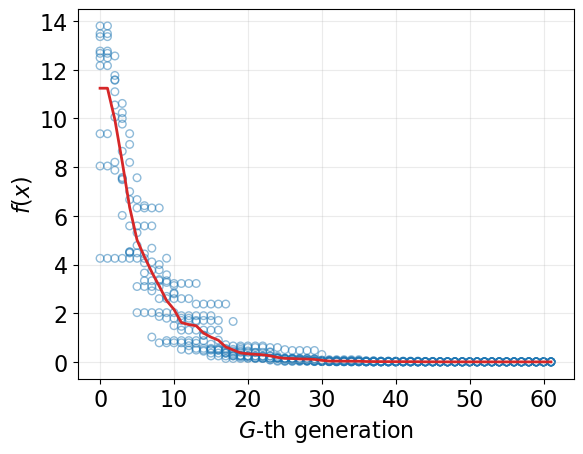

In [13]:
fig, ax = plt.subplots()

mean_fit_over_pop = []
for idx_hist in range(len(hist_x_pso)):
  x_pso = hist_x_pso[idx_hist]
  fit_vals = hist_fitness_vals[idx_hist]
  ax.scatter(np.ones_like(x_pso[:, 0])*idx_hist, fit_vals,
    color="tab:blue", facecolor="None", s=30, alpha=0.5)
  mean_fit = np.mean(fit_vals)
  mean_fit_over_pop = np.append(mean_fit_over_pop, [mean_fit])

# print(mean_fit_over_pop)
ax.plot(mean_fit_over_pop, color="tab:red", lw=2)

ax.set_xlabel("$G$-th generation")
ax.set_ylabel("$f(x)$")
ax.grid("on")

plt.show(fig)

Plot initial and the best solution 

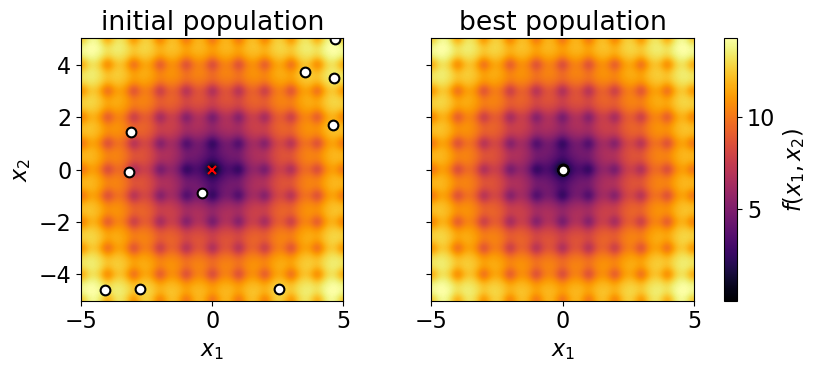

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

# -- left plot
Nx = 1000
x1_range = [-5., 5.]
x2_range = [-5., 5.]

x1_space = np.linspace(x1_range[0], x1_range[1], Nx)
x2_space = np.linspace(x2_range[0], x2_range[1], Nx)
x1_mesh, x2_mesh = np.meshgrid(x1_space, x2_space)
f_vals = obj_func(x1_mesh, x2_mesh)

axes[0].imshow(f_vals, extent=[*x1_range, *x2_range], origin="lower", cmap="inferno") 
axes[0].plot(*[0, 0], linestyle="none", marker="x", markeredgecolor="r", markeredgewidth=1.5)
skip_points = 1
axes[0].plot(hist_x_pso[0, 0::skip_points, 0],
              hist_x_pso[0, 0::skip_points, 1], linestyle="None", marker="o", 
              markerfacecolor="w", markeredgecolor="k", markeredgewidth=1.5,
              markersize=7)

axes[0].set_title("initial population")
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")
axes[0].set_xlim([-5, 5])
axes[0].set_ylim([-5, 5])

im_handler = axes[1].imshow(f_vals, extent=[*x1_range, *x2_range], origin="lower", cmap="inferno") 
axes[1].plot([0], [0], linestyle="none", marker="x", markeredgecolor="r", markeredgewidth=1.5)
skip_points = 1
# axes[1].plot(hist_x_ga[-1, 0::skip_points, 0],
#               hist_x_ga[-1, 0::skip_points, 1], linestyle="None", marker="o")
axes[1].plot(hist_x_pso[-1, 0::skip_points, 0],
              hist_x_pso[-1, 0::skip_points, 1], linestyle="None", marker="o", 
              markerfacecolor="w", markeredgecolor="k", markeredgewidth=1.5,
              markersize=7)

axes[1].set_title("best population")
axes[1].set_xlabel("$x_1$")
# axes[1].set_ylabel("$x_2$")
axes[1].set_xlim([-5, 5])
axes[1].set_ylim([-5, 5])

# fix the axes[1] position
fig.tight_layout()
ax0_bounds = axes[0].get_position().bounds
ax1_bounds = list(axes[1].get_position().bounds)
ax1_bounds[1] = ax0_bounds[1]     # y0
ax1_bounds[2] = ax0_bounds[2]     # width
ax1_bounds[3] = ax0_bounds[3]     # height
axes[1].set_position(ax1_bounds)

fig.colorbar(im_handler, label="$f(x_1, x_2)$")
fig.subplots_adjust(wspace=-0.5)

plt.show(fig)